In [1]:
import xgcm
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')

In [2]:
label = 'C3'
t = 80
filename = '/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/' + label + '/field'  + '%g.nc' %t
ds = xr.open_dataset(filename, engine='h5netcdf')

In [3]:
L = 200
N = 1024
ds = ds.assign_coords({'zl_g':('zl_g', ds.zl.values-0.5),
                       'zl': ('zl', ds.zl.values),
                       'x_g':('x_g', ds.x.values-L/N/2),
                       'y_g':('y_g', ds.y.values-L/N/2),
                       })

# ds.expand_dims(dim=['x_g','y_g'],create_index_for_new_dim=False)
# ds['xg'] = ds['x'] - L/N/2
# ds['yg'] = ds['y'] - L/N/2
# ds['zlg'] = ds['zl'] - 0.5

grid = xgcm.Grid(ds, 
                 coords={
                     'X':{'center':'x', 'left':'x_g'},
                     'Y':{'center':'y', 'left':'y_g'},
                     'Z':{'center':'zl', 'left':'zl_g'},
                 },
                 periodic={'X':'True','Y':'True','Z':'False'},
                 boundary={'Z':'fill'},
                 fill_value={'Z':0})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x --> left
  * left     x_g --> center
Y Axis (periodic, boundary=None):
  * center   y --> left
  * left     y_g --> center
Z Axis (periodic, boundary='fill'):
  * center   zl --> left
  * left     zl_g --> center

In [1]:
from mlpython.utils import dissipation_layer
ds = dissipation_layer(ds, grid)

NameError: name 'ds' is not defined

(-5.0, 1.0)

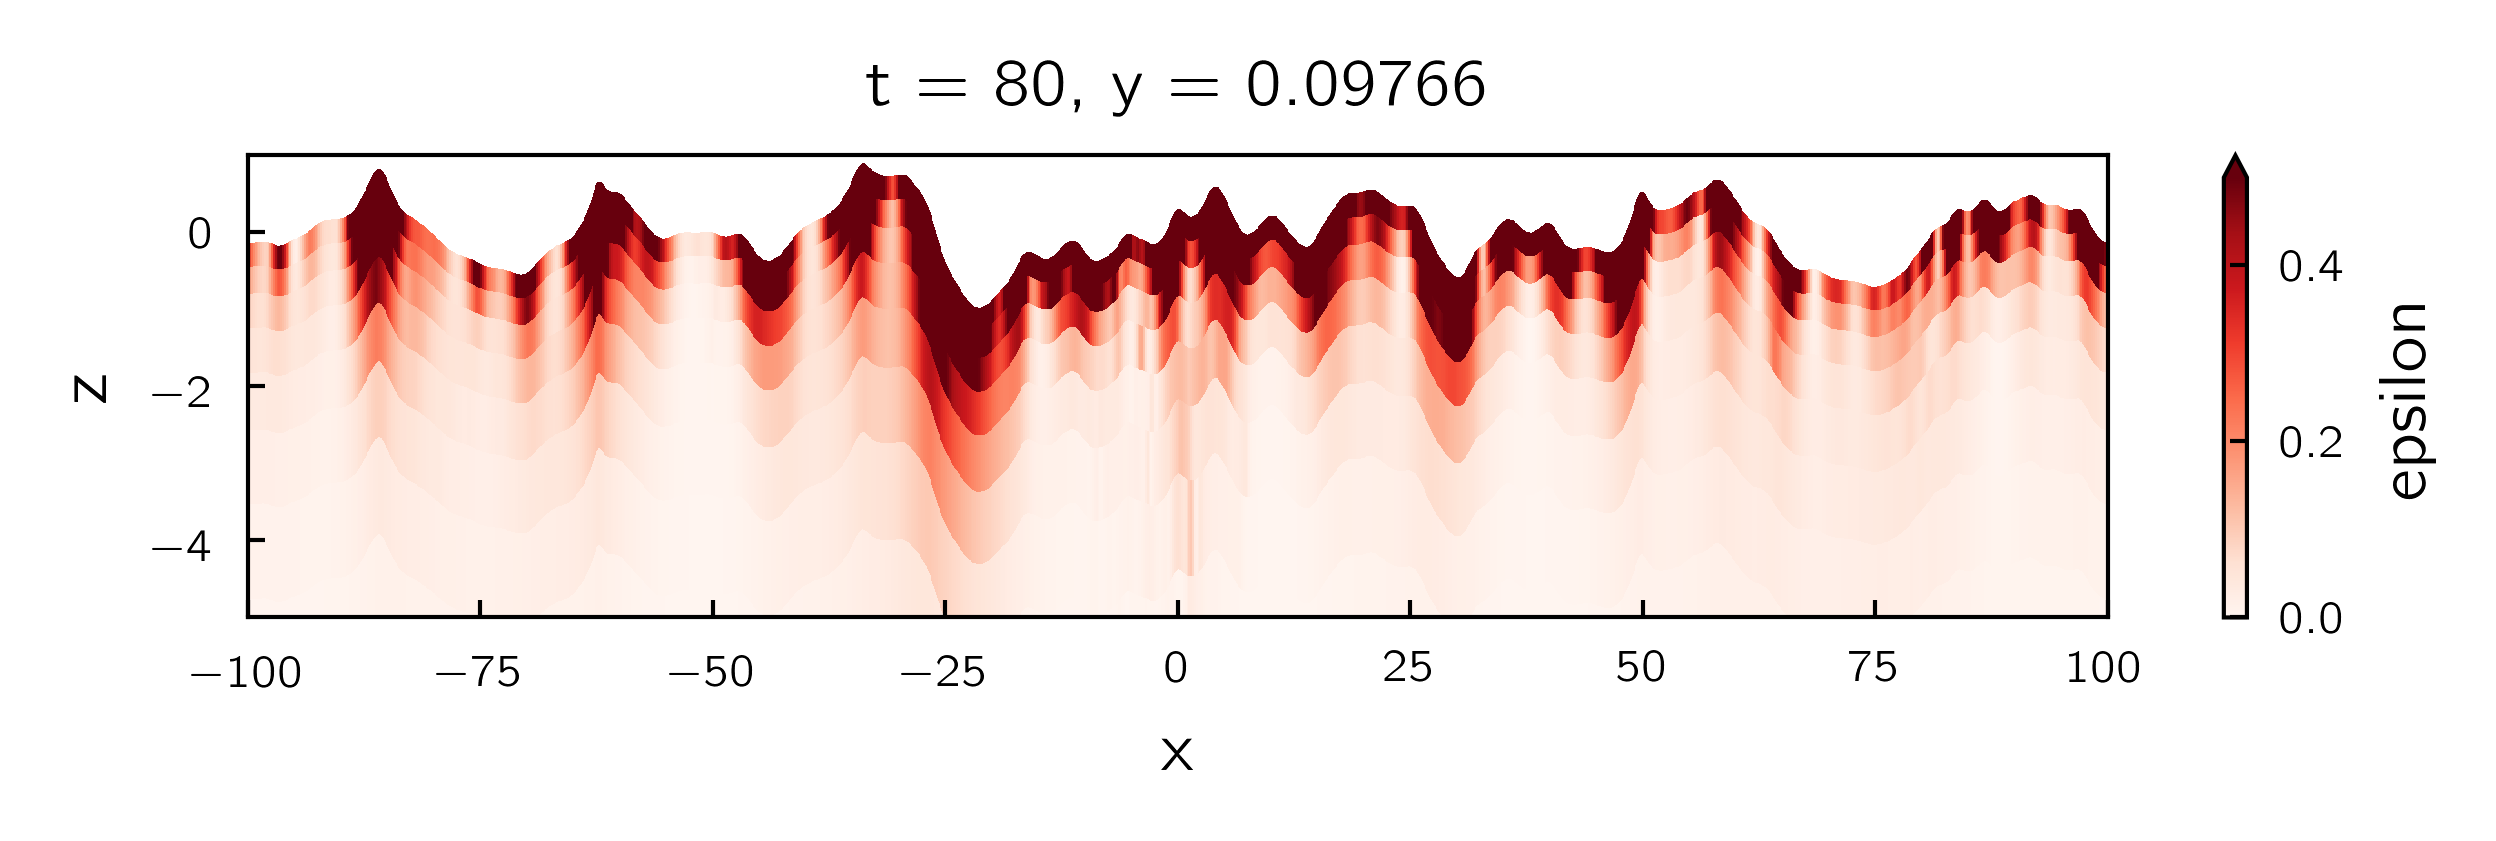

In [6]:
fig = plt.figure(figsize=[5,1])
ds.epsilon.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=0, cmap='Reds')
plt.ylim([-5,1])

(-5.0, 1.0)

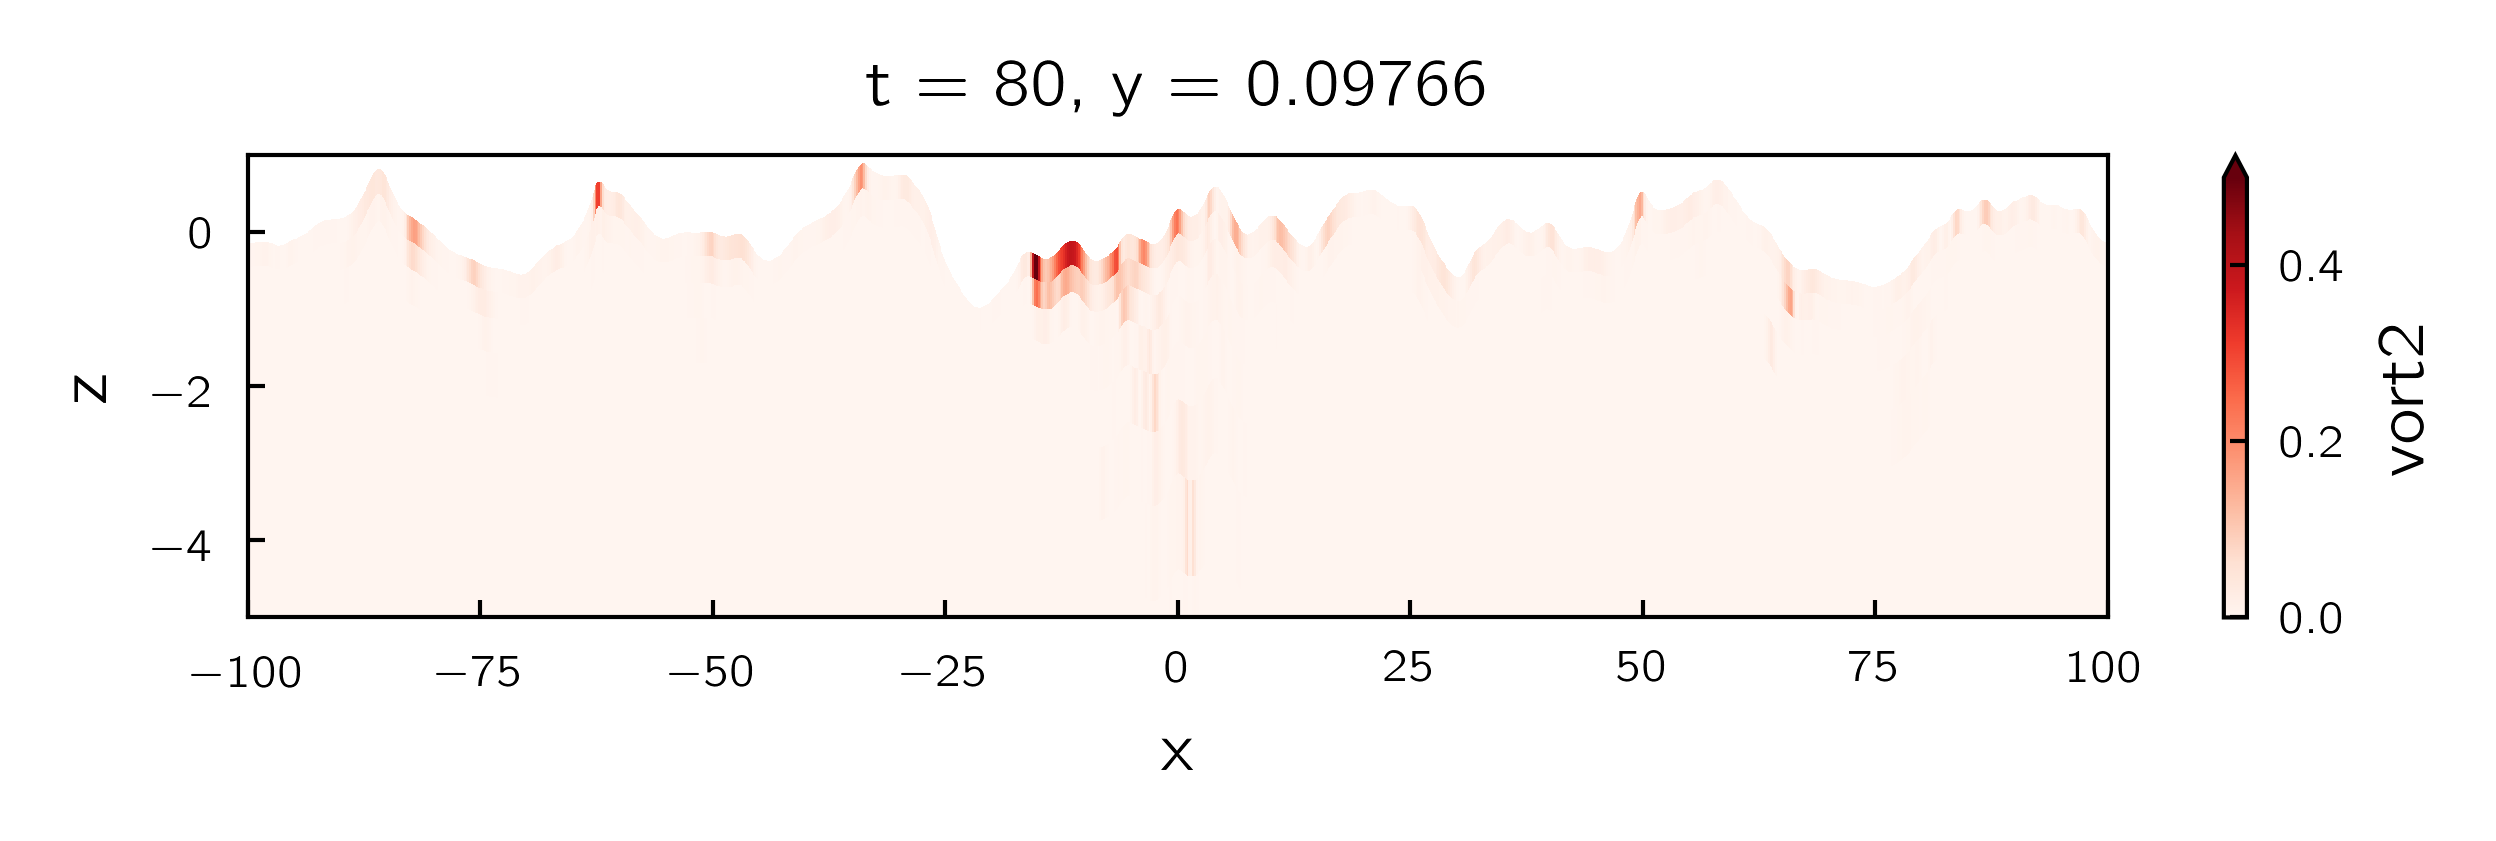

In [10]:
fig = plt.figure(figsize=[5,1])
ds.vort2.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=0, cmap='Reds')
plt.ylim([-5,1])

(-5.0, 1.0)

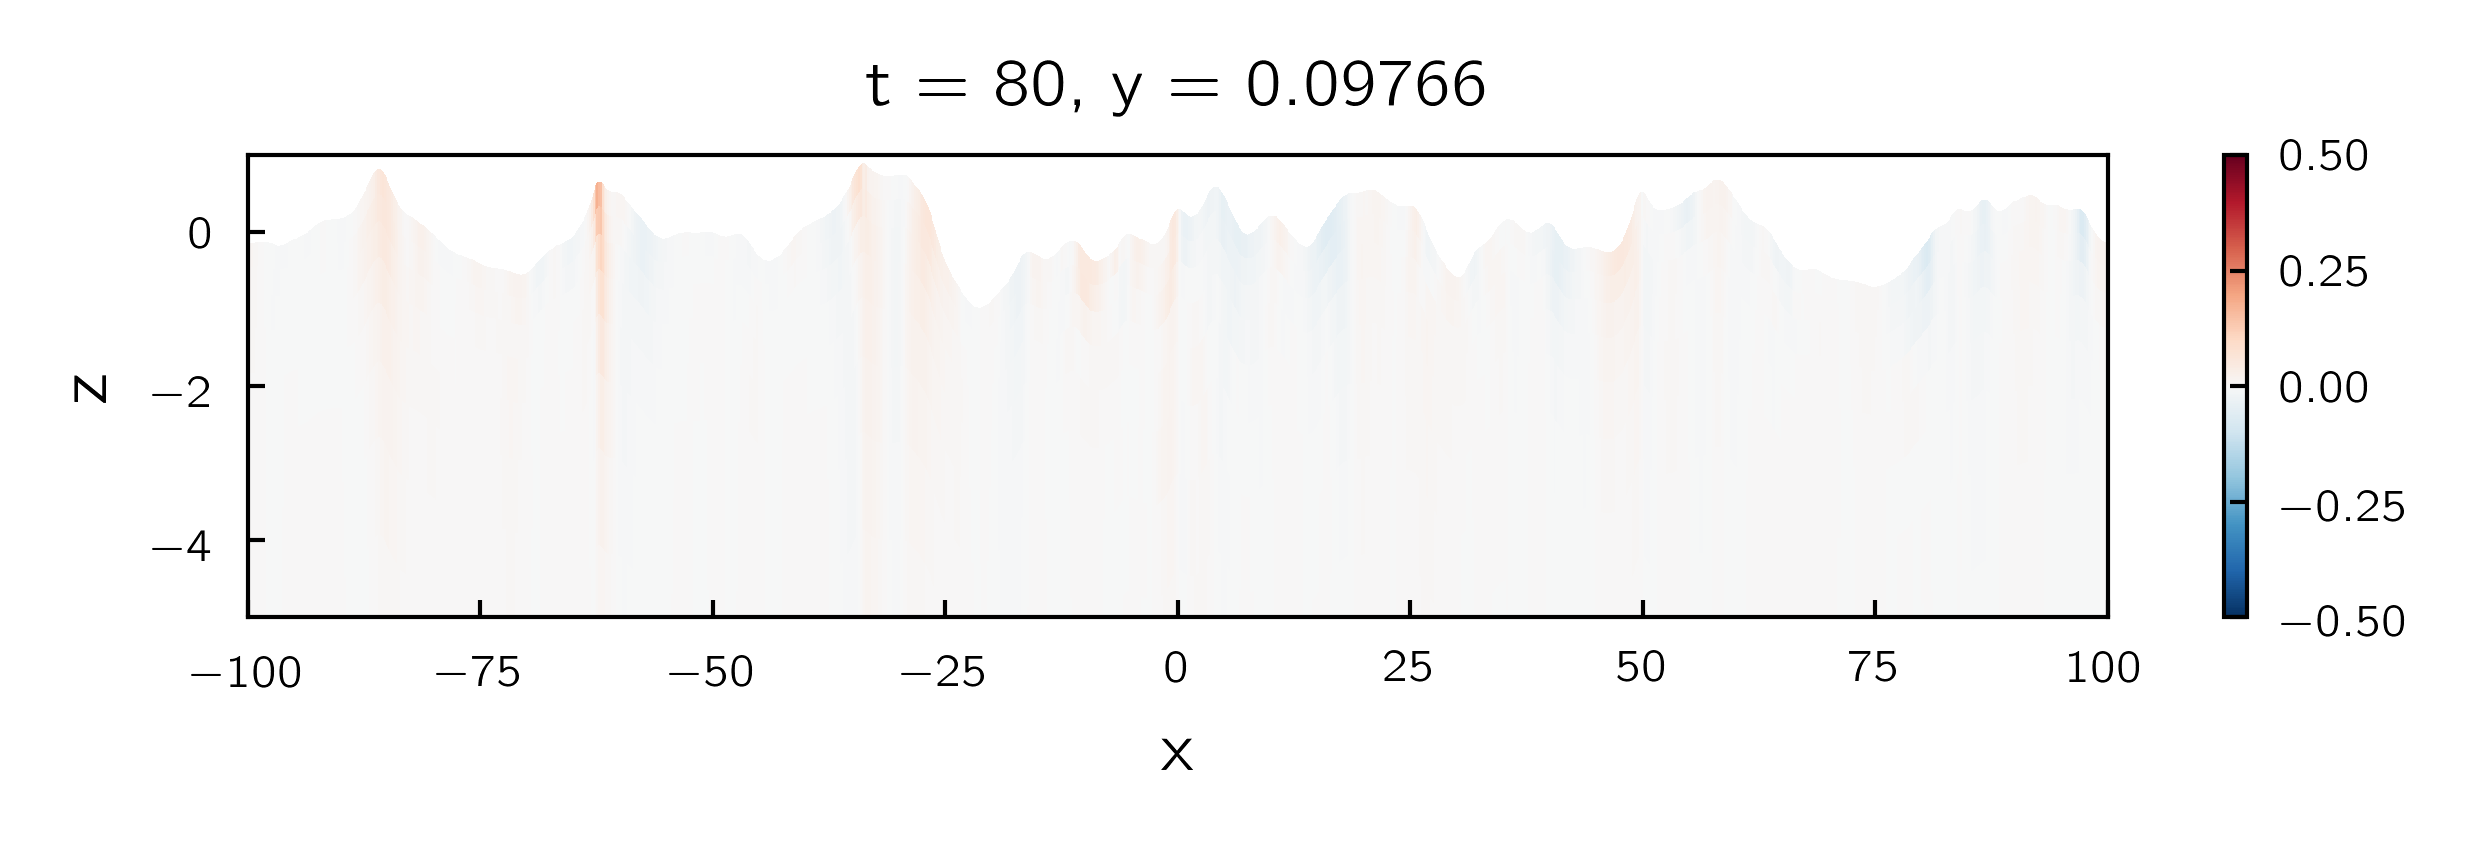

In [159]:
fig = plt.figure(figsize=[5,1])
diff = ds.omegaz - ds.omegazp
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

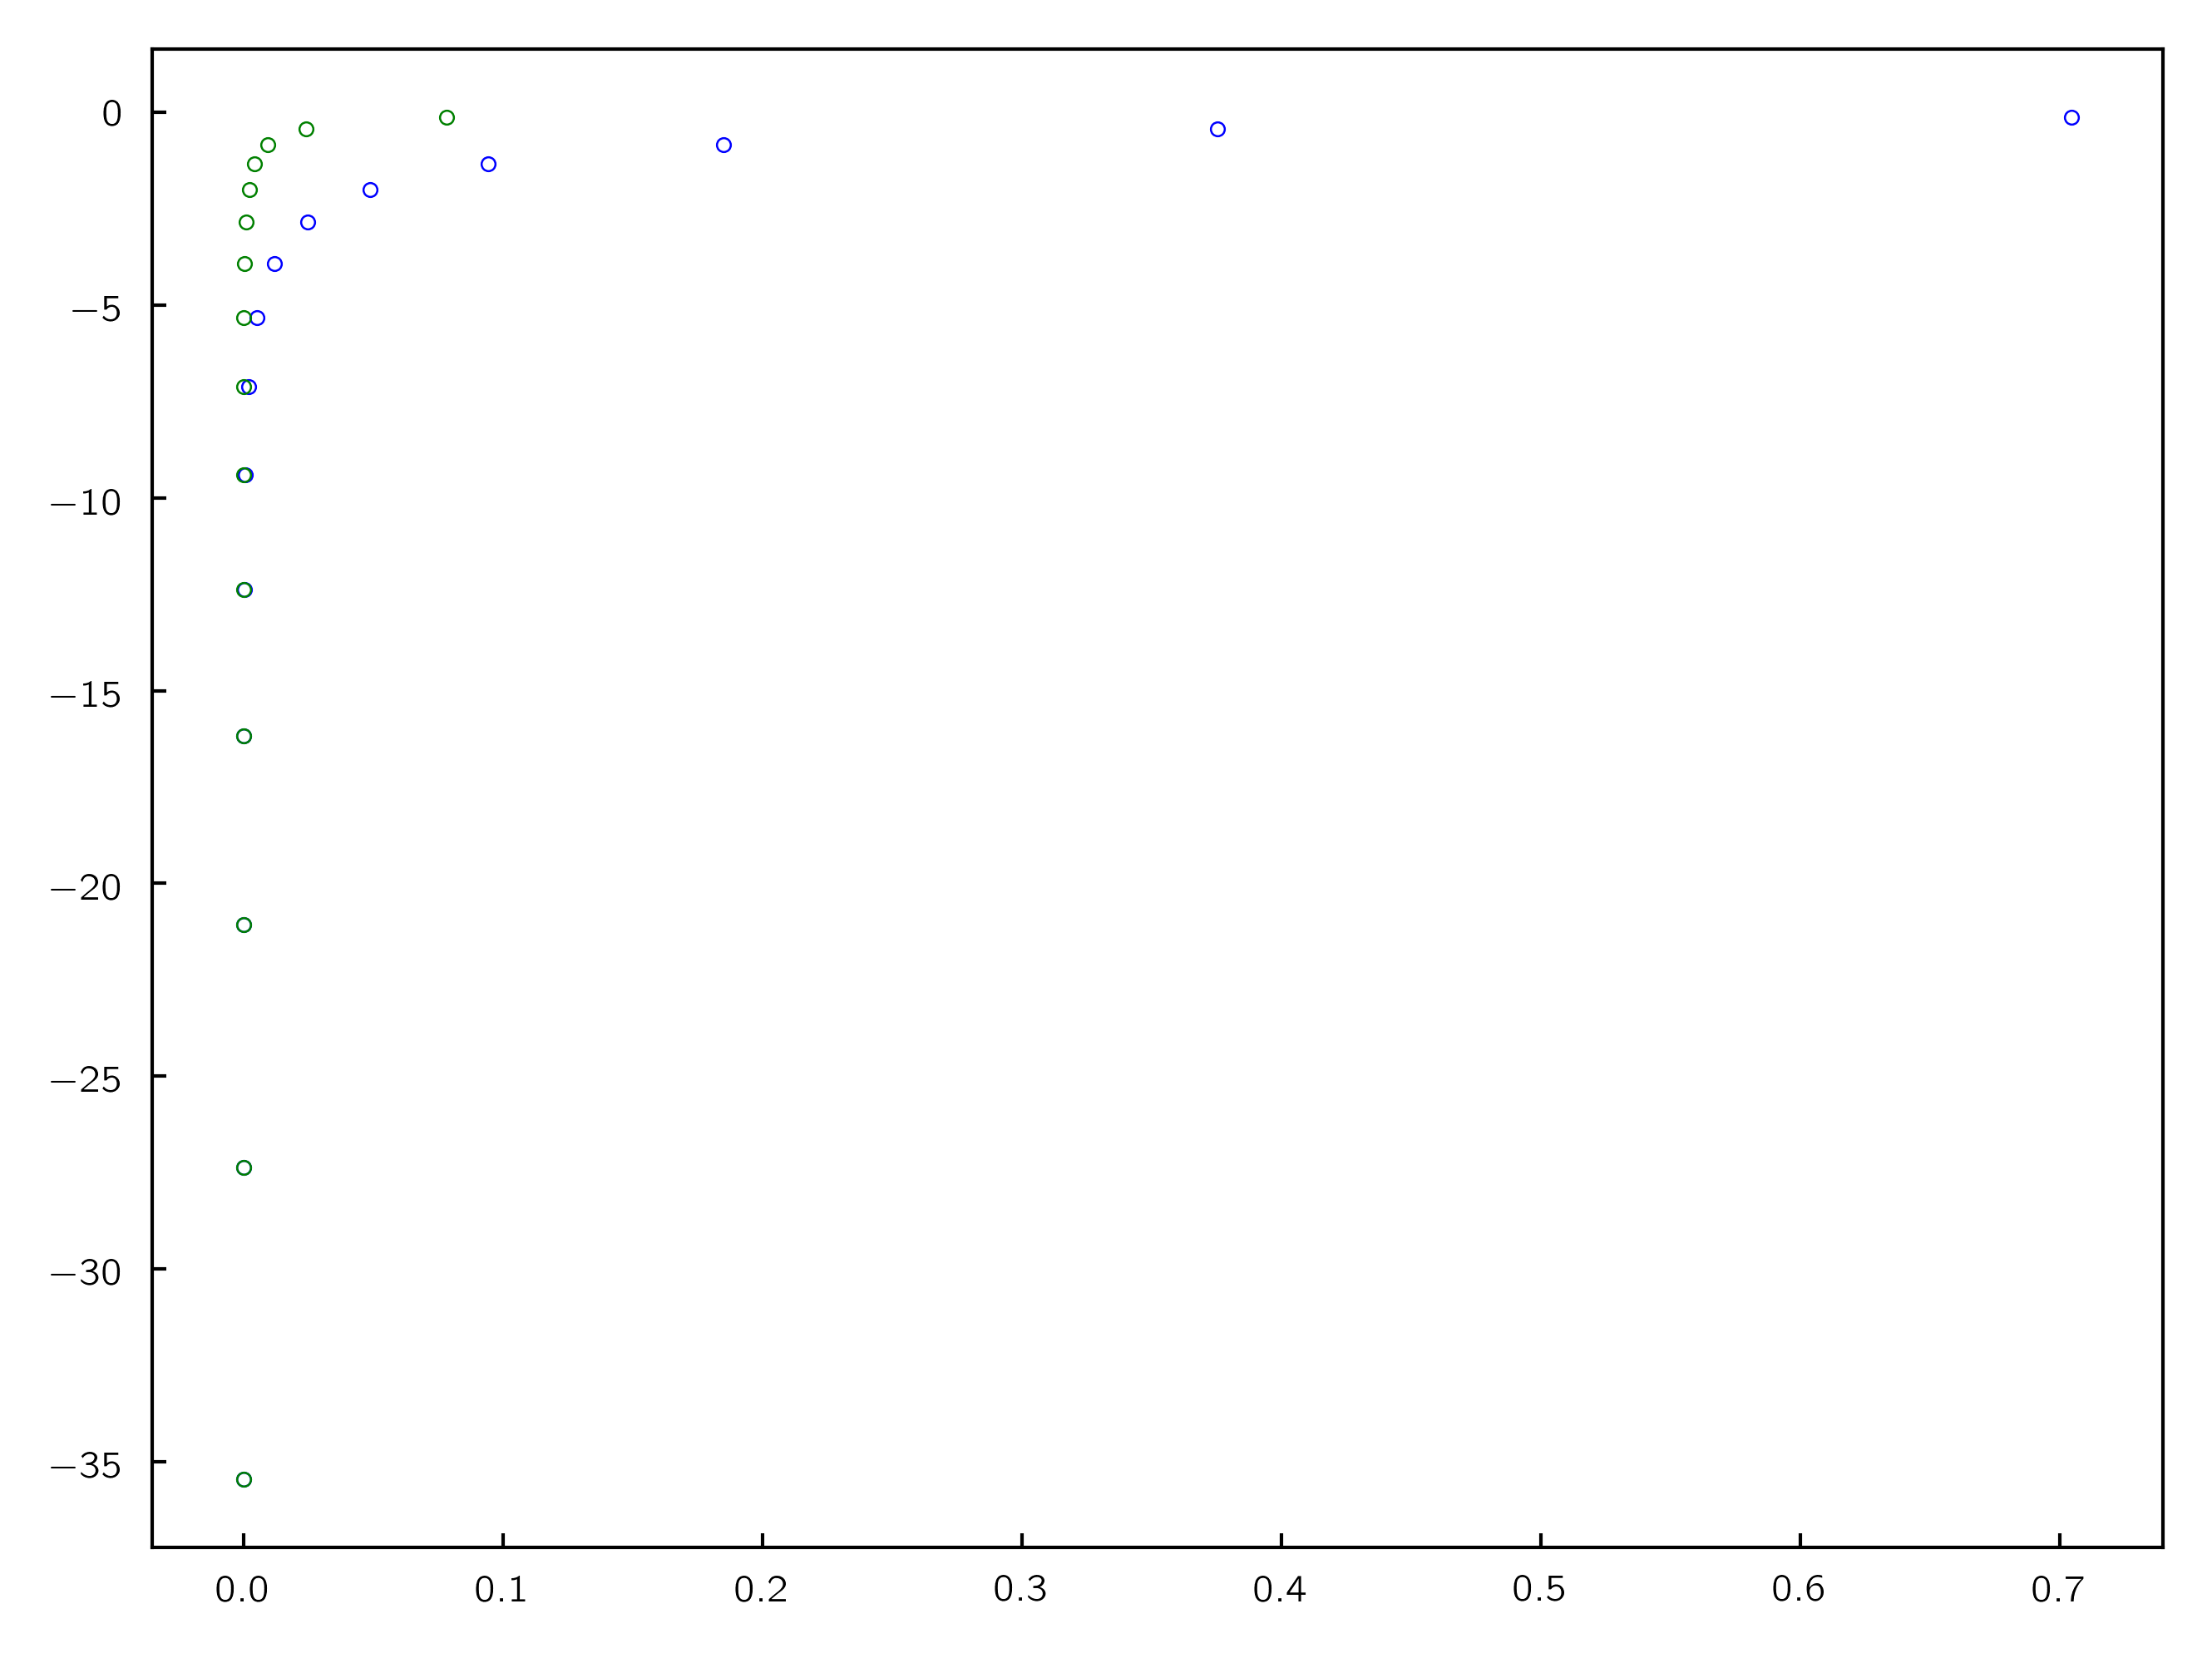

In [169]:
plt.plot(ds.epsilon.isel(t=0).mean(dim=['x','y']), ds.z.mean(dim=['x','y']), 'o')
plt.plot(ds.vort2.isel(t=0).mean(dim=['x','y']), ds.z.mean(dim=['x','y']), 'o')

(-5.0, 1.0)

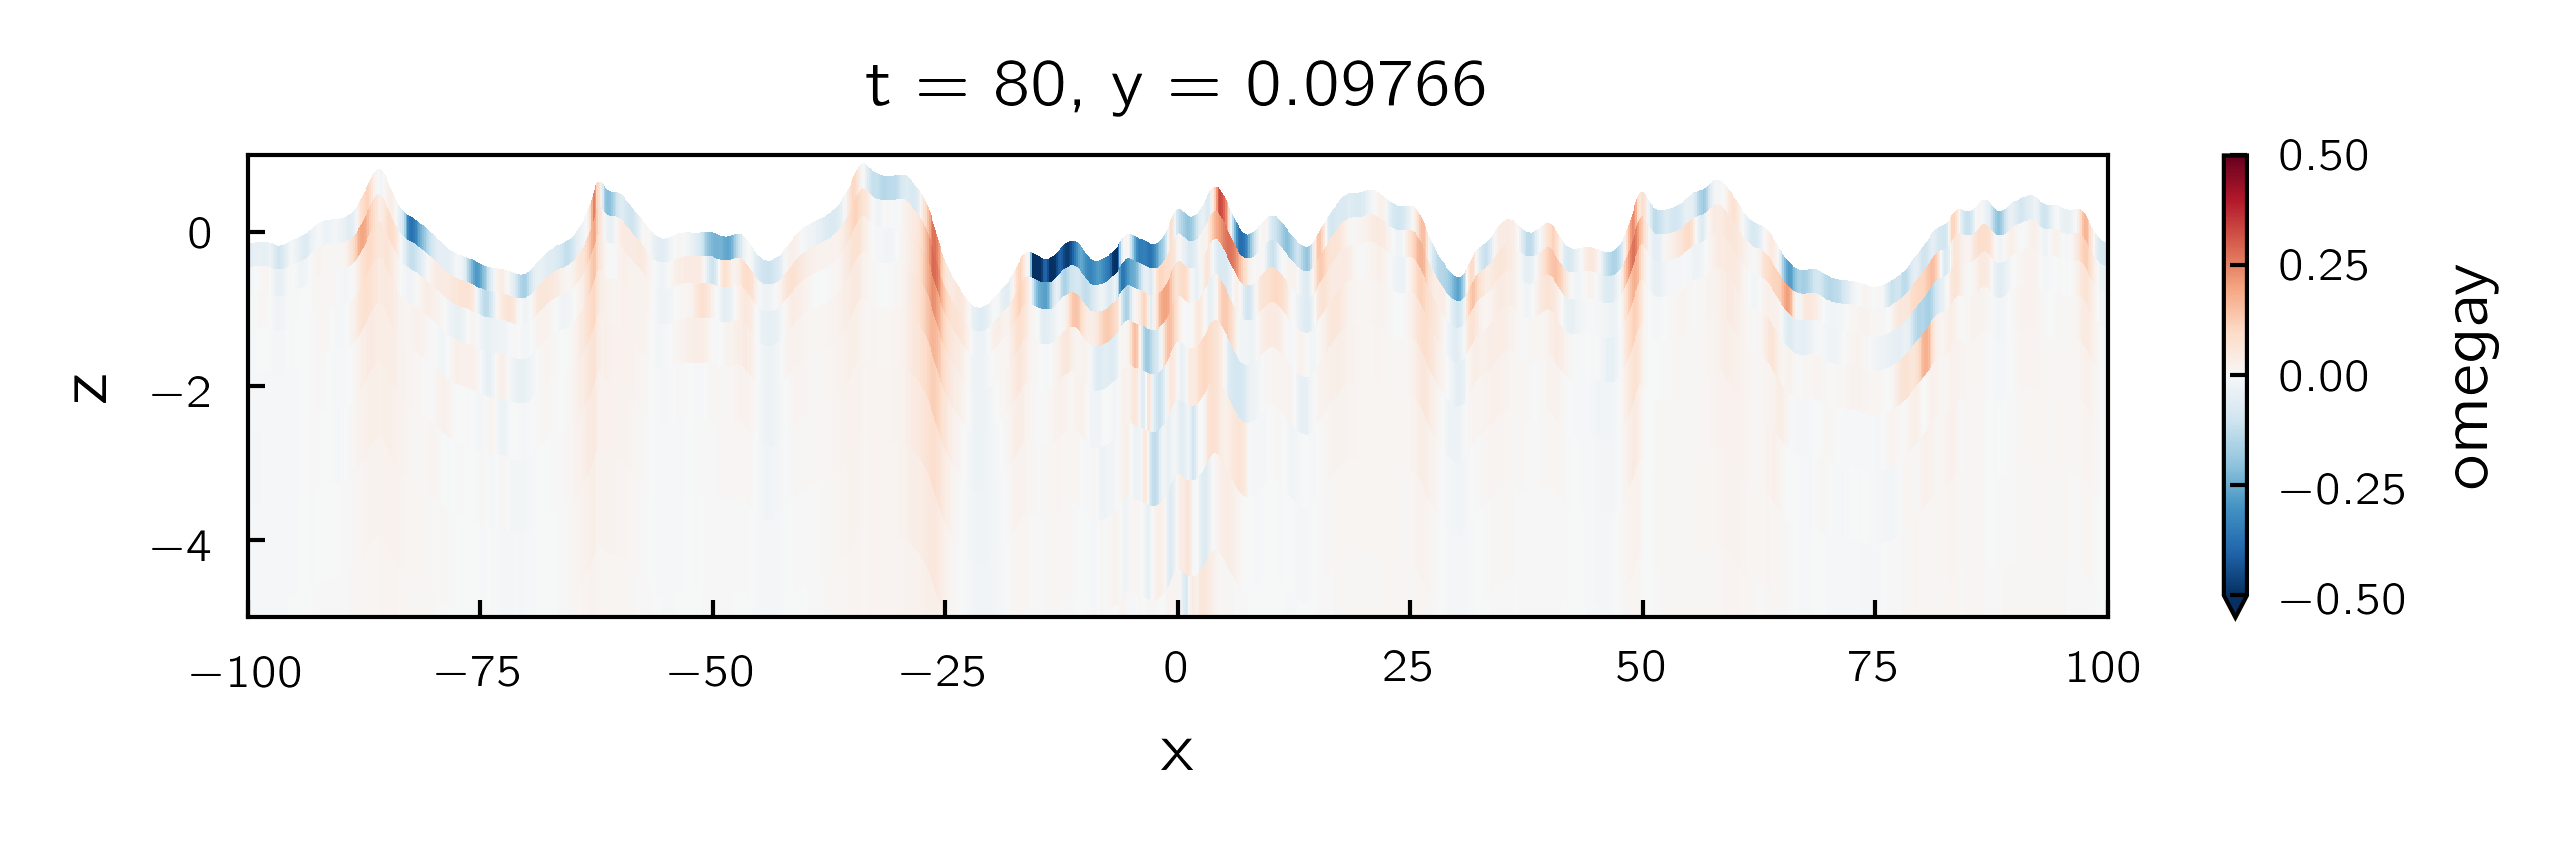

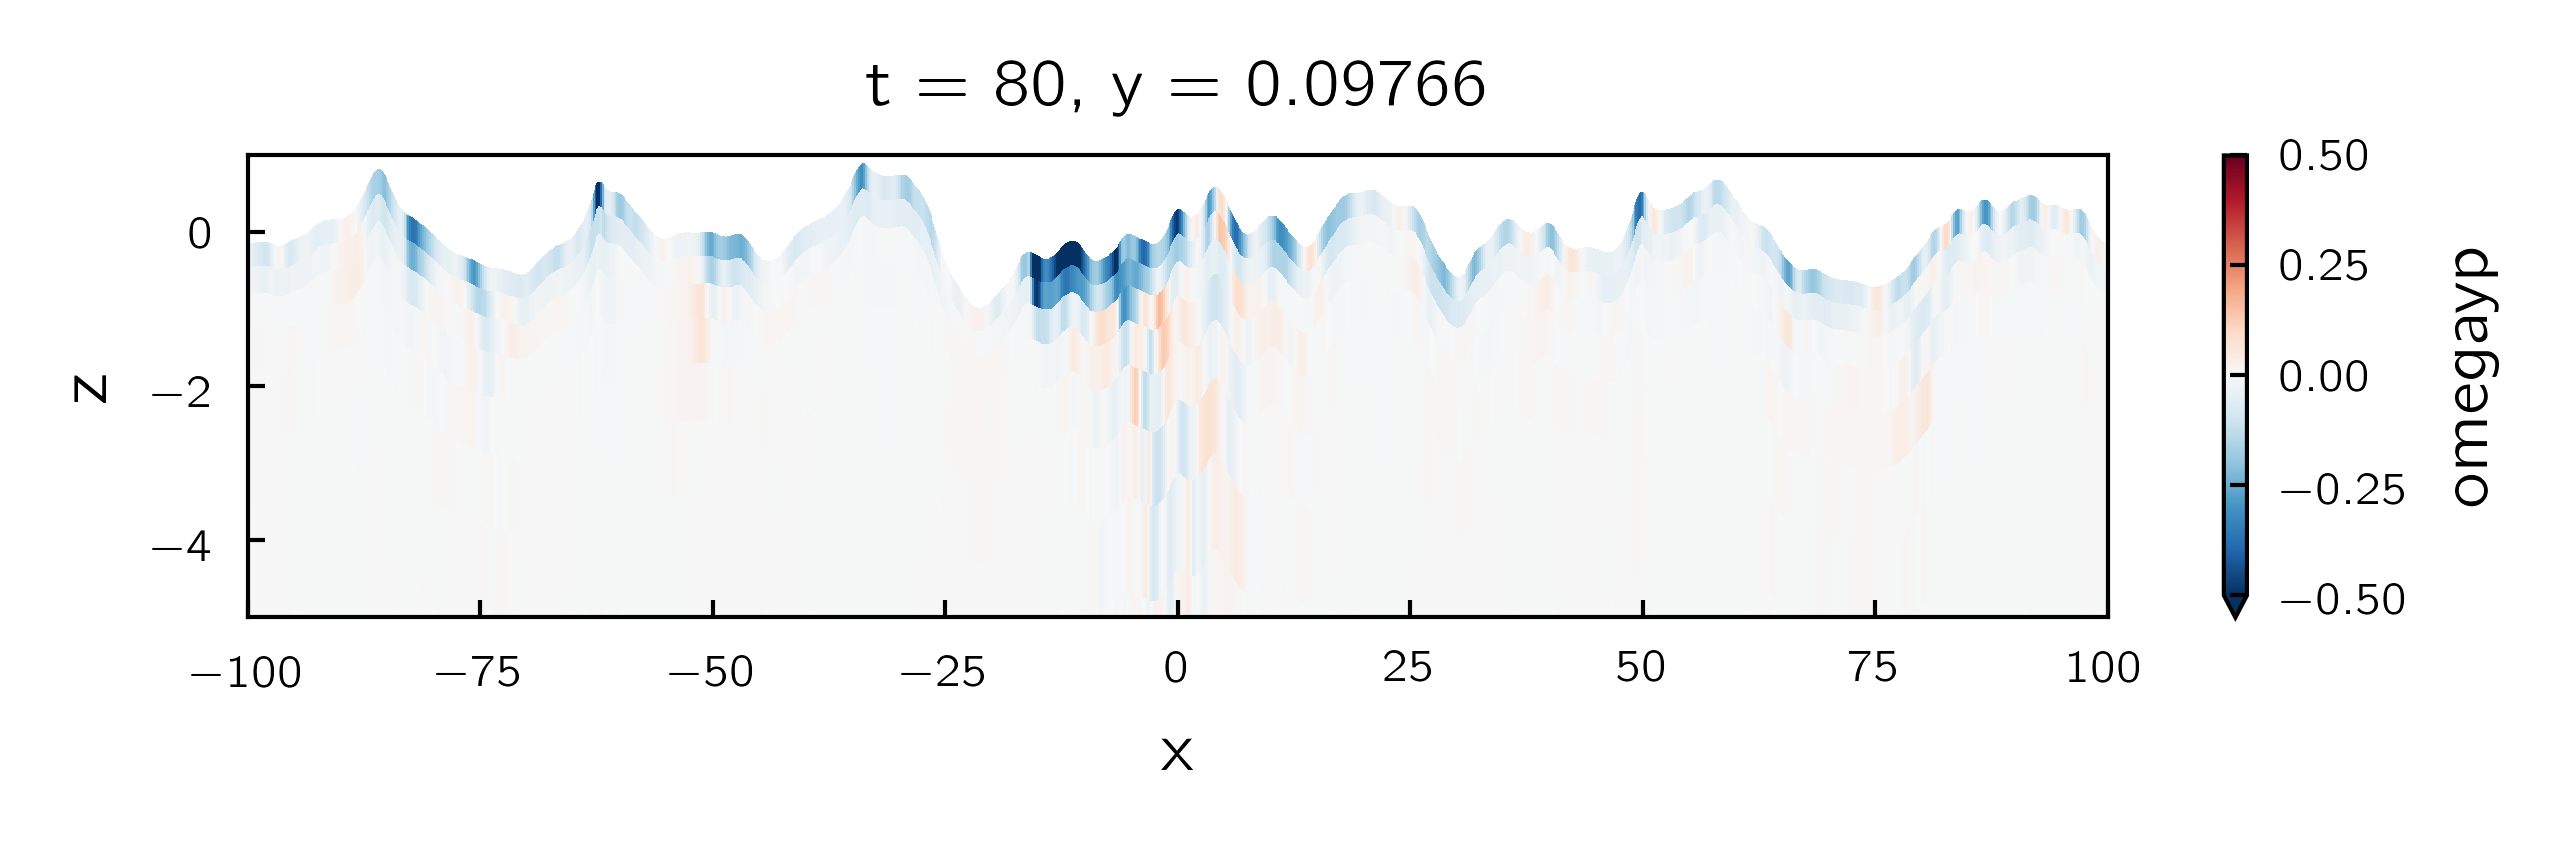

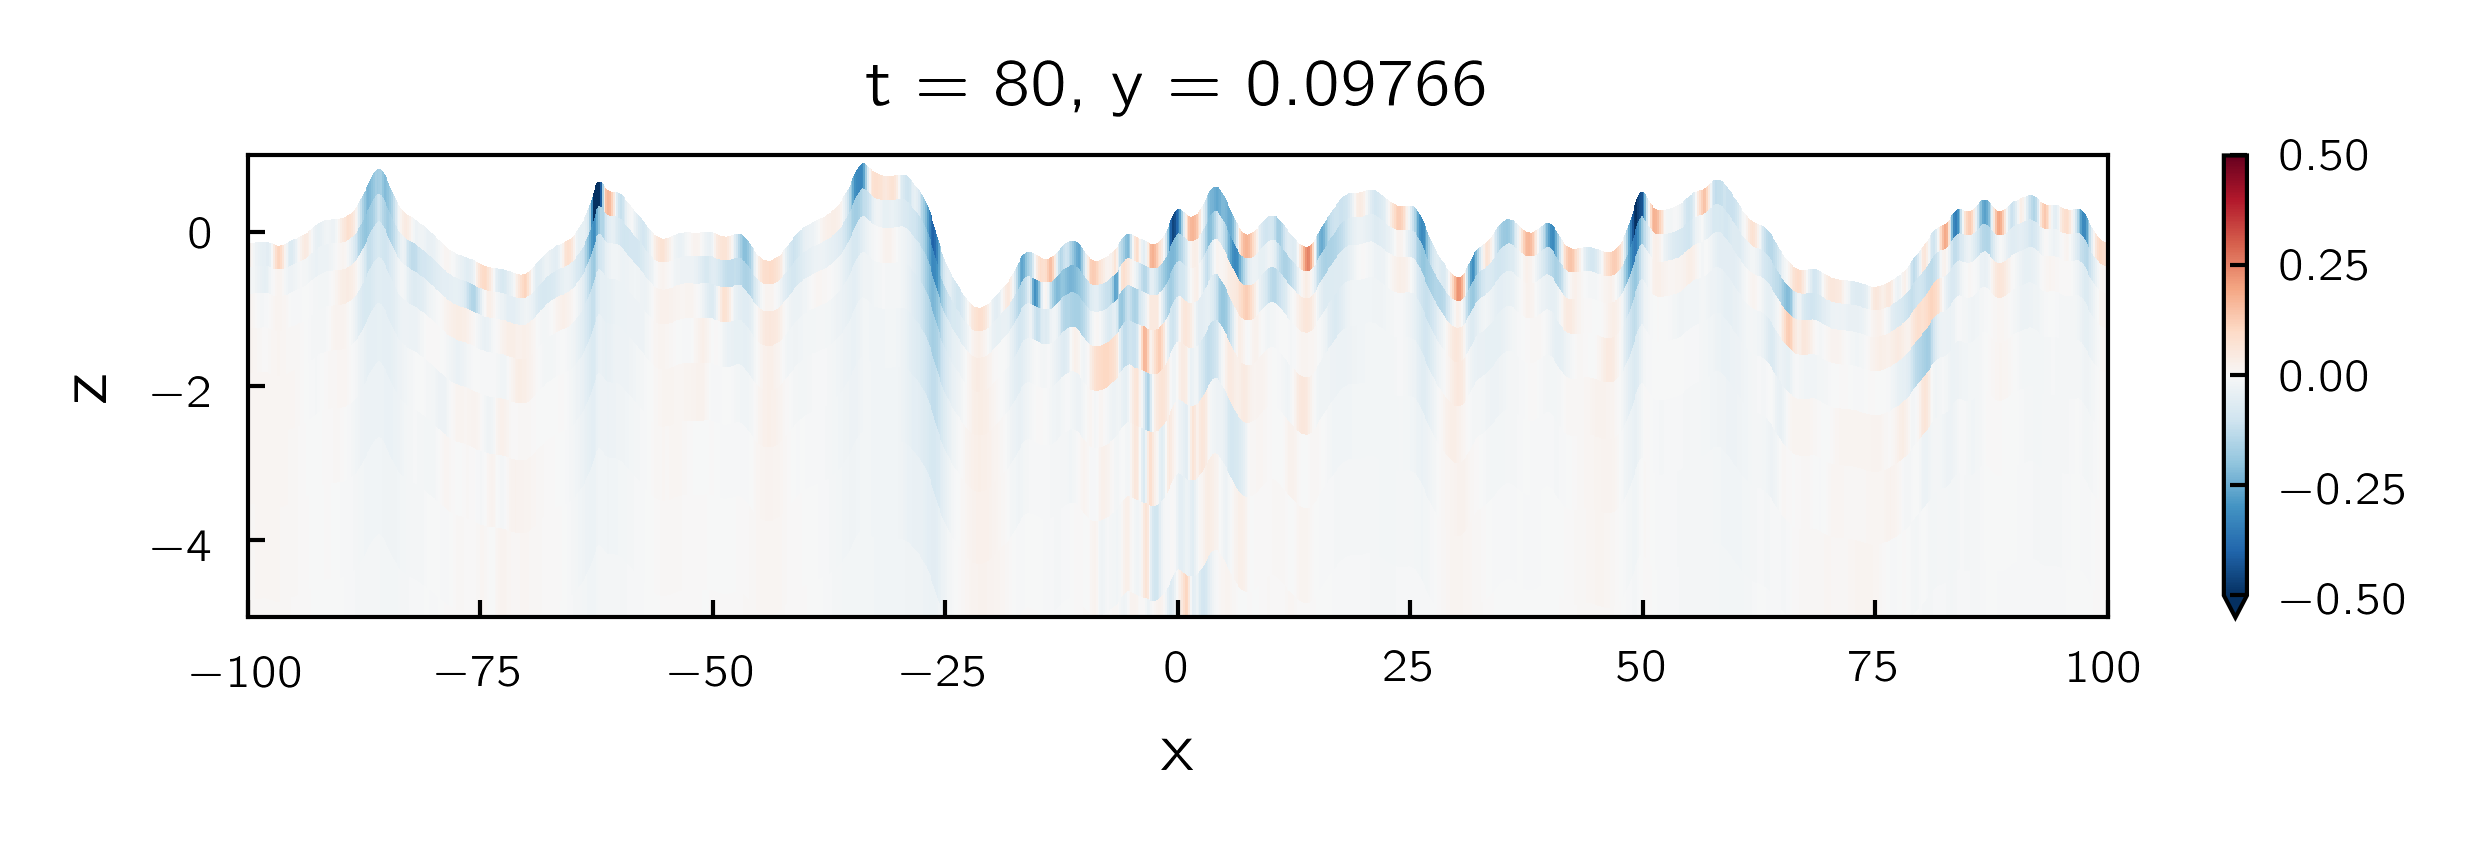

In [13]:
fig = plt.figure(figsize=[5,1])
(-ds.omegay).isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])
fig = plt.figure(figsize=[5,1])
ds.omegayp.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])
fig = plt.figure(figsize=[5,1])
diff = (ds.omegay + ds.omegayp)
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

(-5.0, 1.0)

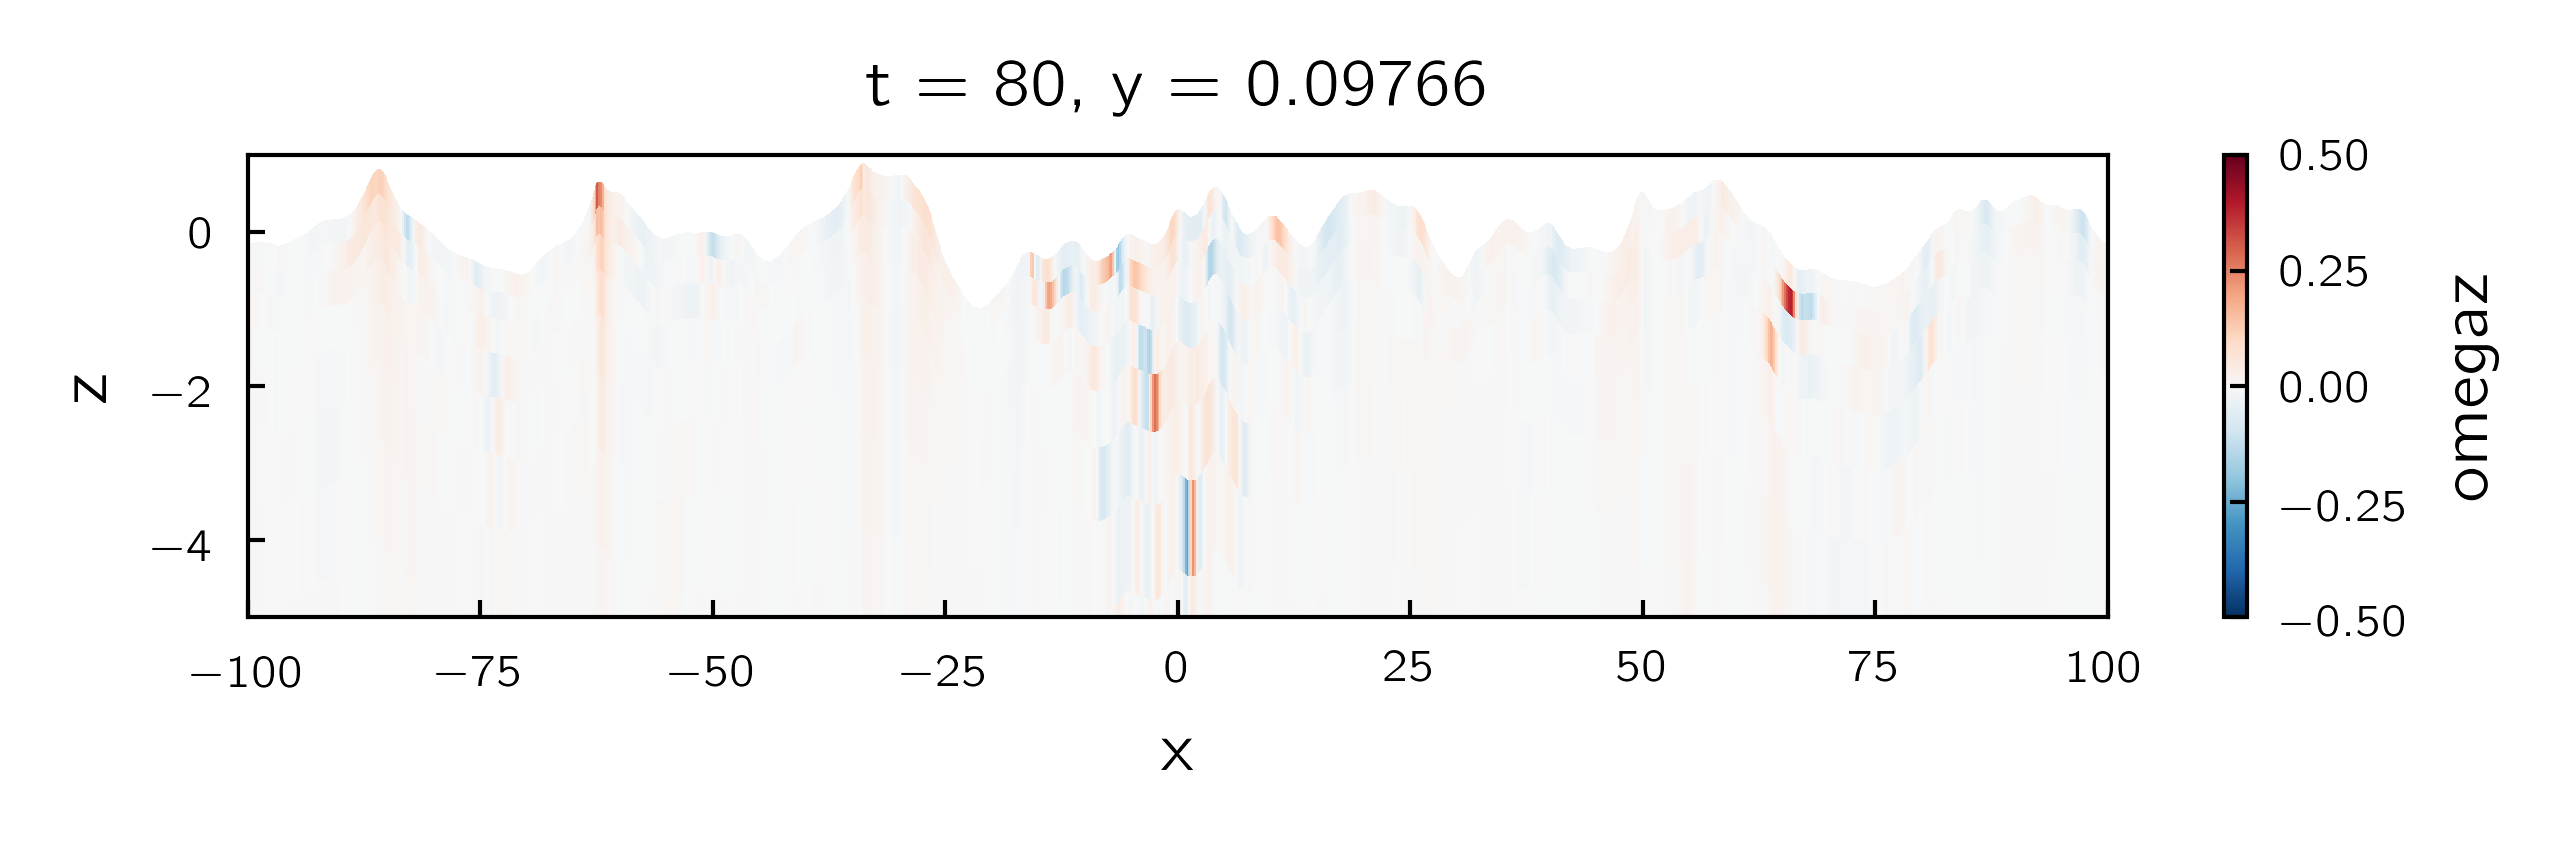

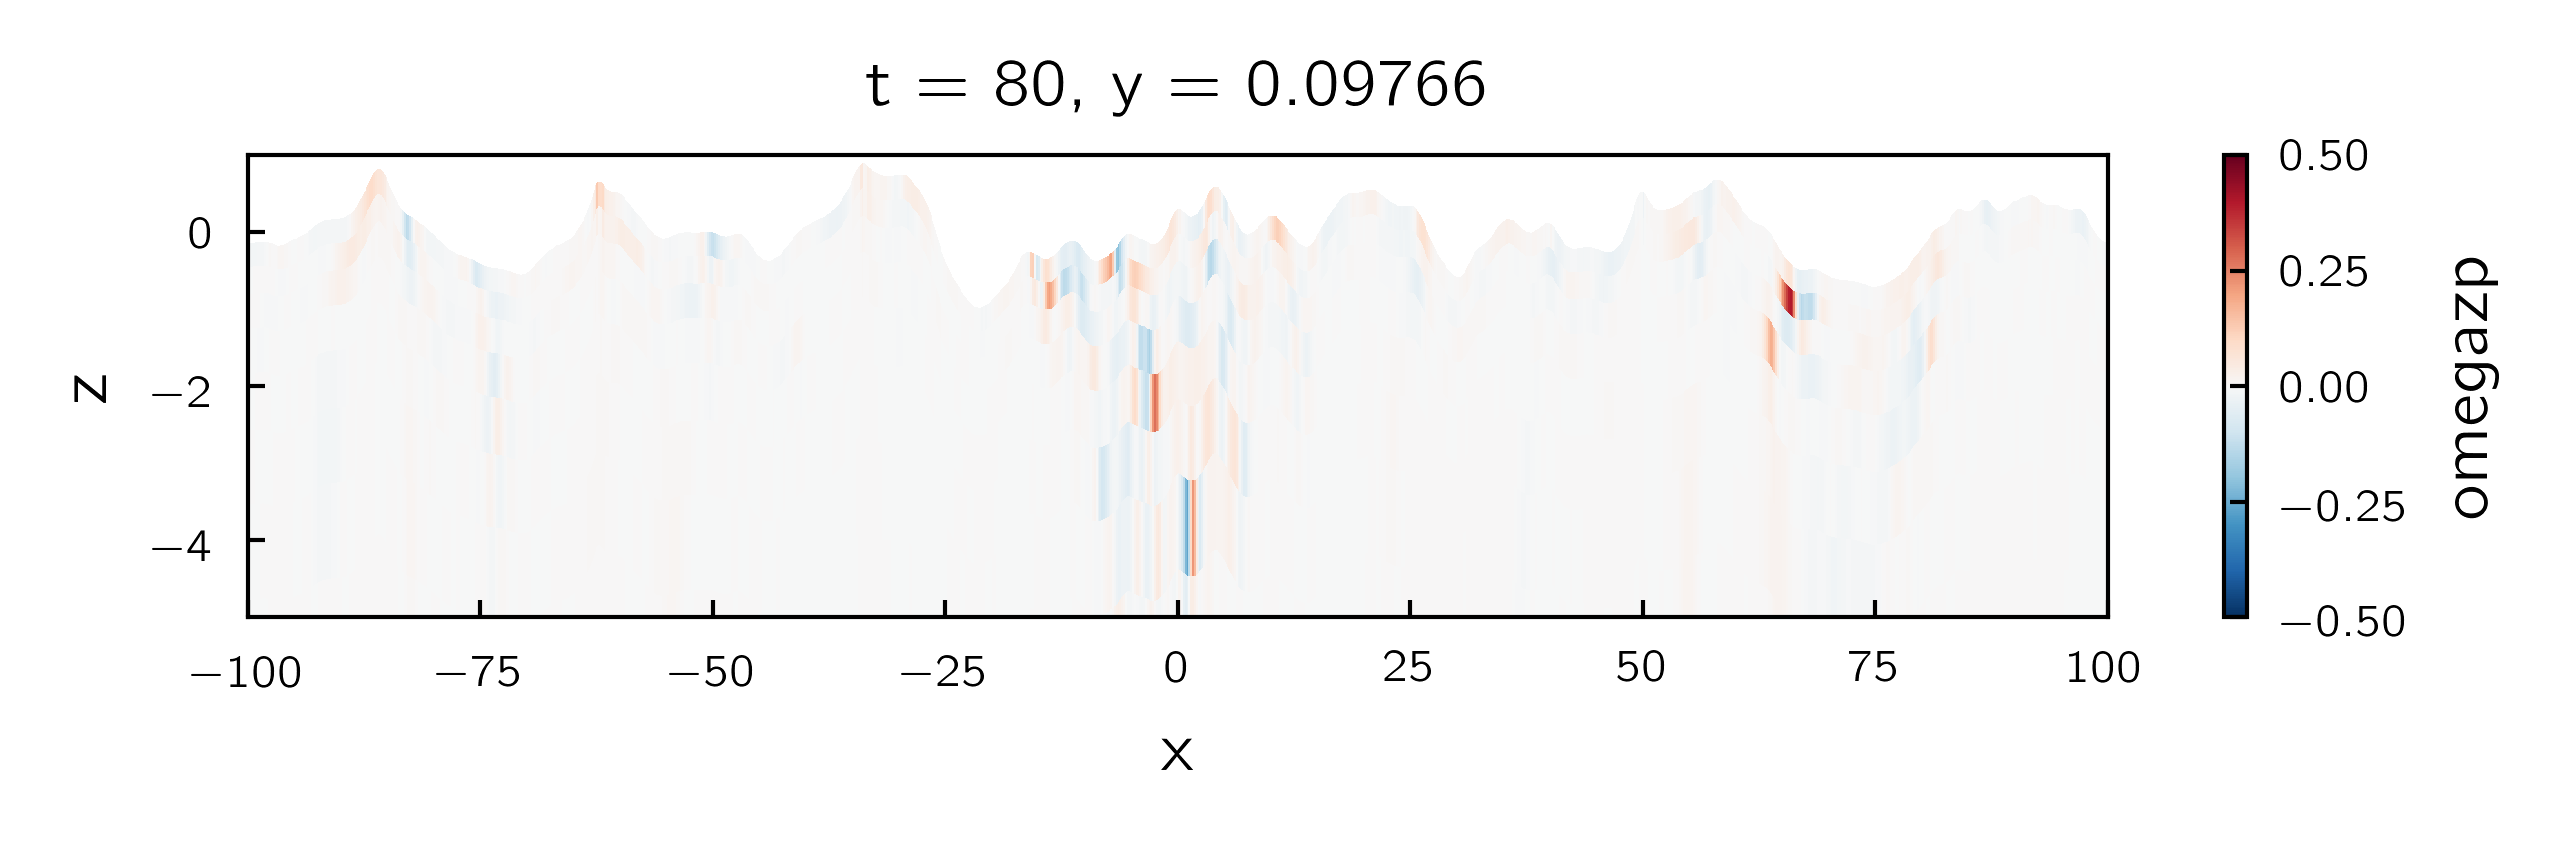

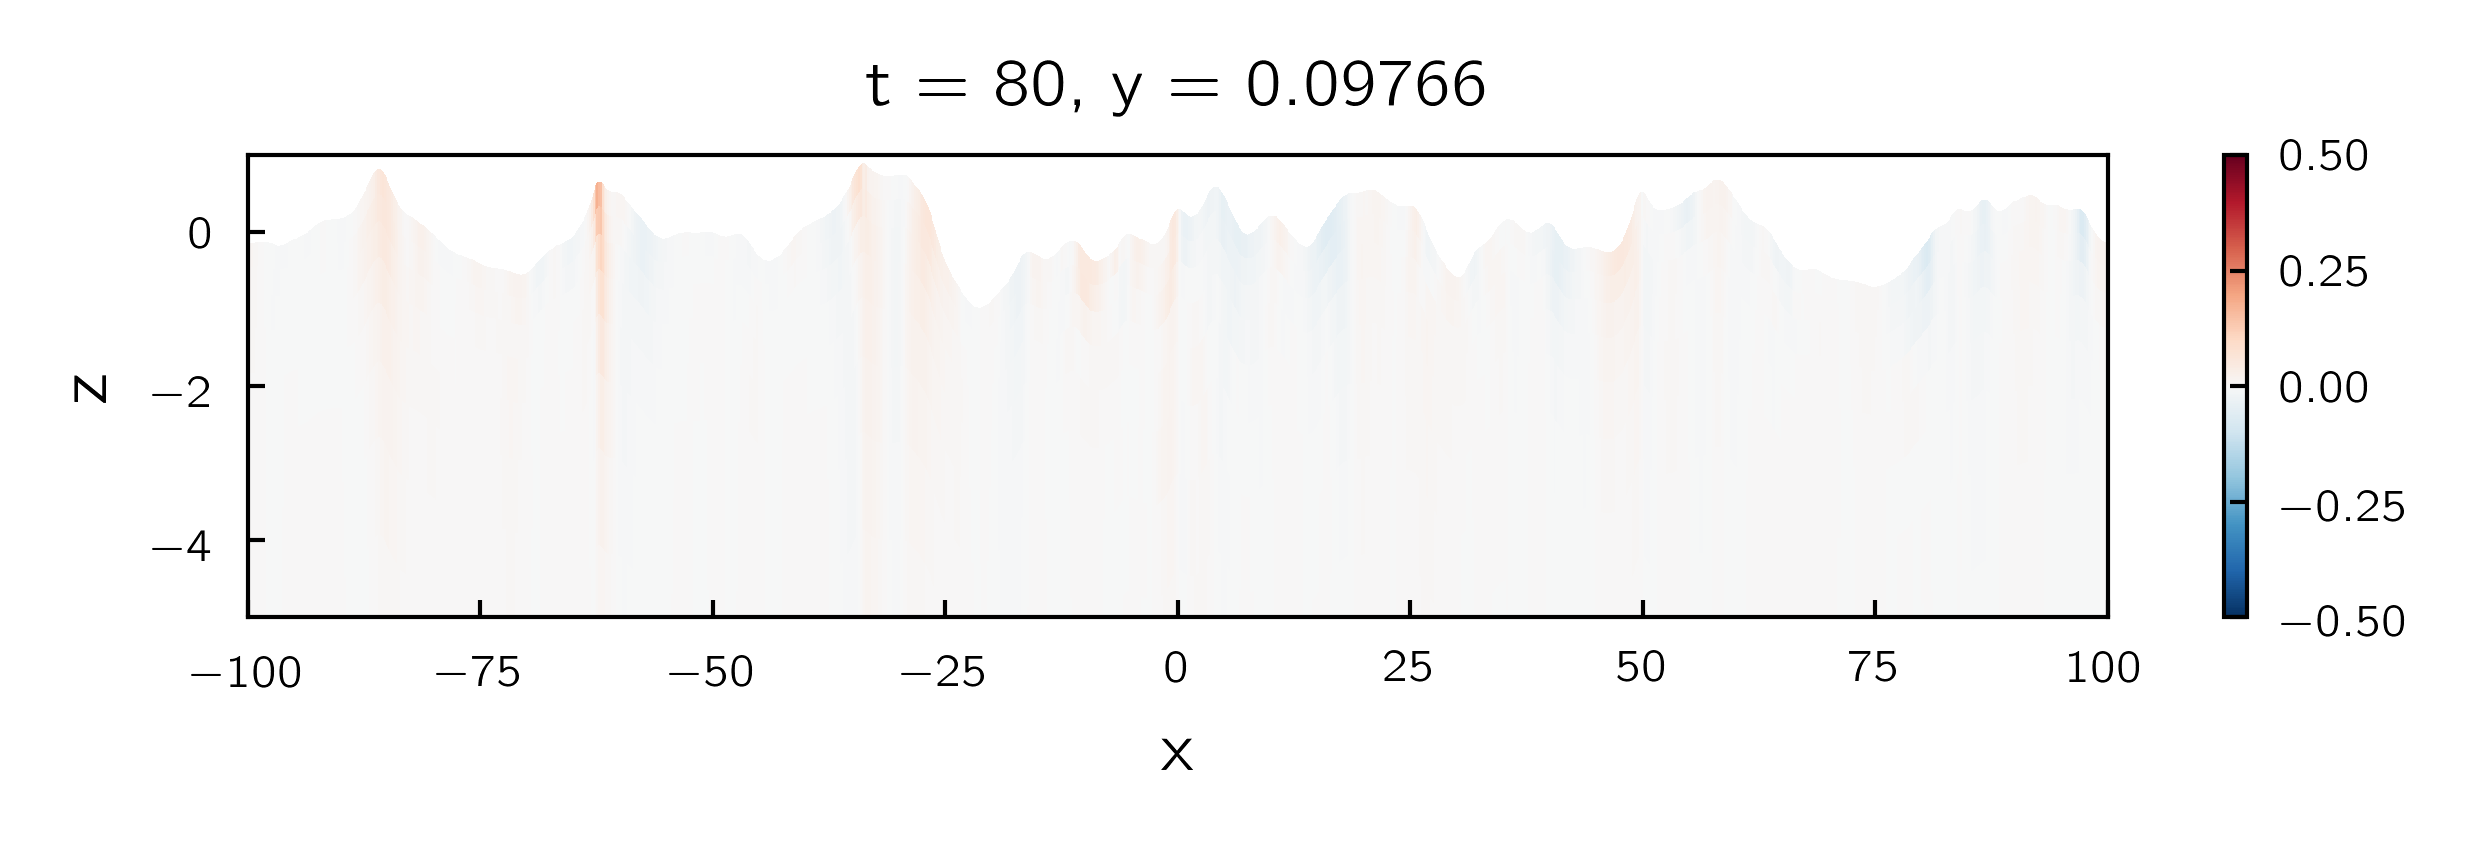

In [14]:
fig = plt.figure(figsize=[5,1])
ds.omegaz.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])
fig = plt.figure(figsize=[5,1])
ds.omegazp.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])
fig = plt.figure(figsize=[5,1])
diff = (ds.omegaz - ds.omegazp)
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

## First interpolate

In [135]:
def dissipation_cartesian(ds, grid):
    
    delta = ds.x[1]-ds.x[0]
    deltaz = ds.z[1]-ds.z[0]
    
    ds['dudx'] = grid.interp(grid.diff(ds.ux, 'X'), 'X')/delta
    ds['dudy'] = grid.interp(grid.diff(ds.ux, 'Y'), 'Y')/delta
    ds['dudz'] = grid.interp(grid.diff(ds.ux, 'Z'), 'Z')/deltaz
    ds['dvdx'] = grid.interp(grid.diff(ds.uy, 'X'), 'X')/delta
    ds['dvdy'] = grid.interp(grid.diff(ds.uy, 'Y'), 'Y')/delta
    ds['dvdz'] = grid.interp(grid.diff(ds.uy, 'Z'), 'Z')/deltaz
    ds['dwdx'] = grid.interp(grid.diff(ds.uz, 'X'), 'X')/delta
    ds['dwdy'] = grid.interp(grid.diff(ds.uz, 'Y'), 'Y')/delta
    ds['dwdz'] = grid.interp(grid.diff(ds.uz, 'Z'), 'Z')/deltaz
    
    ds['epsilon'] = 2*(ds.dudx**2 + ((ds.dudy + ds.dvdx)/2.)**2 + ((ds.dudz+ds.dwdx)/2.)**2 + ds.dvdy**2 + ((ds.dvdz+ds.dwdy)/2.)**2 + ds.dwdz**2)
    
    ds['omegaxp'] = ds.dwdy - ds.dvdz
    ds['omegayp'] = ds.dudz - ds.dwdx
    ds['omegazp'] = ds.dvdx - ds.dudy
    ds['vort2'] = ds.omegaxp**2 + ds.omegayp**2 + ds.omegazp**2
    
    return ds

In [130]:
from mlpython.utils import interpz
from dask.diagnostics import ProgressBar

def interp_ds (ds, znew):
    with ProgressBar():
        ux_interp = interpz(znew, ds.z, ds.ux, fill_value=0).compute()
        uy_interp = interpz(znew, ds.z, ds.uy, fill_value=0).compute()
        uz_interp = interpz(znew, ds.z, ds.uz, fill_value=0).compute()
    ds_interp = xr.Dataset(data_vars={
                                'ux':(['x','y','z'], ux_interp.values),
                                'uy':(['x','y','z'], uy_interp.values),
                                'uz':(['x','y','z'], uz_interp.values)},
                           coords={
                               'x':(['x'], ds.x.values),
                               'y':(['y'], ds.y.values),
                               'z':(['z'], znew)})
    return ds_interp

In [131]:
label = 'C3'
t = 80
filename = '/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/' + label + '/field'  + '%g.nc' %t
ds_ = xr.open_dataset(filename, engine='h5netcdf')
znew = np.arange(-5,1,0.1)
ds_interp = interp_ds (ds_.isel(t=0), znew)


/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:13: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (


In [137]:
dx = 200/1024.
dz = znew[1] - znew[0]
ds_interp = ds_interp.assign_coords({'z_g':('z_g', ds_interp.z.values-dz/2.),
                       'x_g':('x_g', ds_interp.x.values-dx/2.),
                       'y_g':('y_g', ds_interp.y.values-dx/2.),
                       })

grid_interp = xgcm.Grid(ds_interp, 
                 coords={
                     'X':{'center':'x', 'left':'x_g'},
                     'Y':{'center':'y', 'left':'y_g'},
                     'Z':{'center':'z', 'left':'z_g'},
                 },
                 periodic={'X':'True','Y':'True','Z':'False'},
                 boundary={'Z':'fill'},
                 fill_value={'Z':0})
grid_interp

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x --> left
  * left     x_g --> center
Y Axis (periodic, boundary=None):
  * center   y --> left
  * left     y_g --> center
Z Axis (periodic, boundary='fill'):
  * center   z --> left
  * left     z_g --> center

In [138]:
ds_interp = dissipation_cartesian(ds_interp, grid_interp)

Text(0.5, 1.0, '')

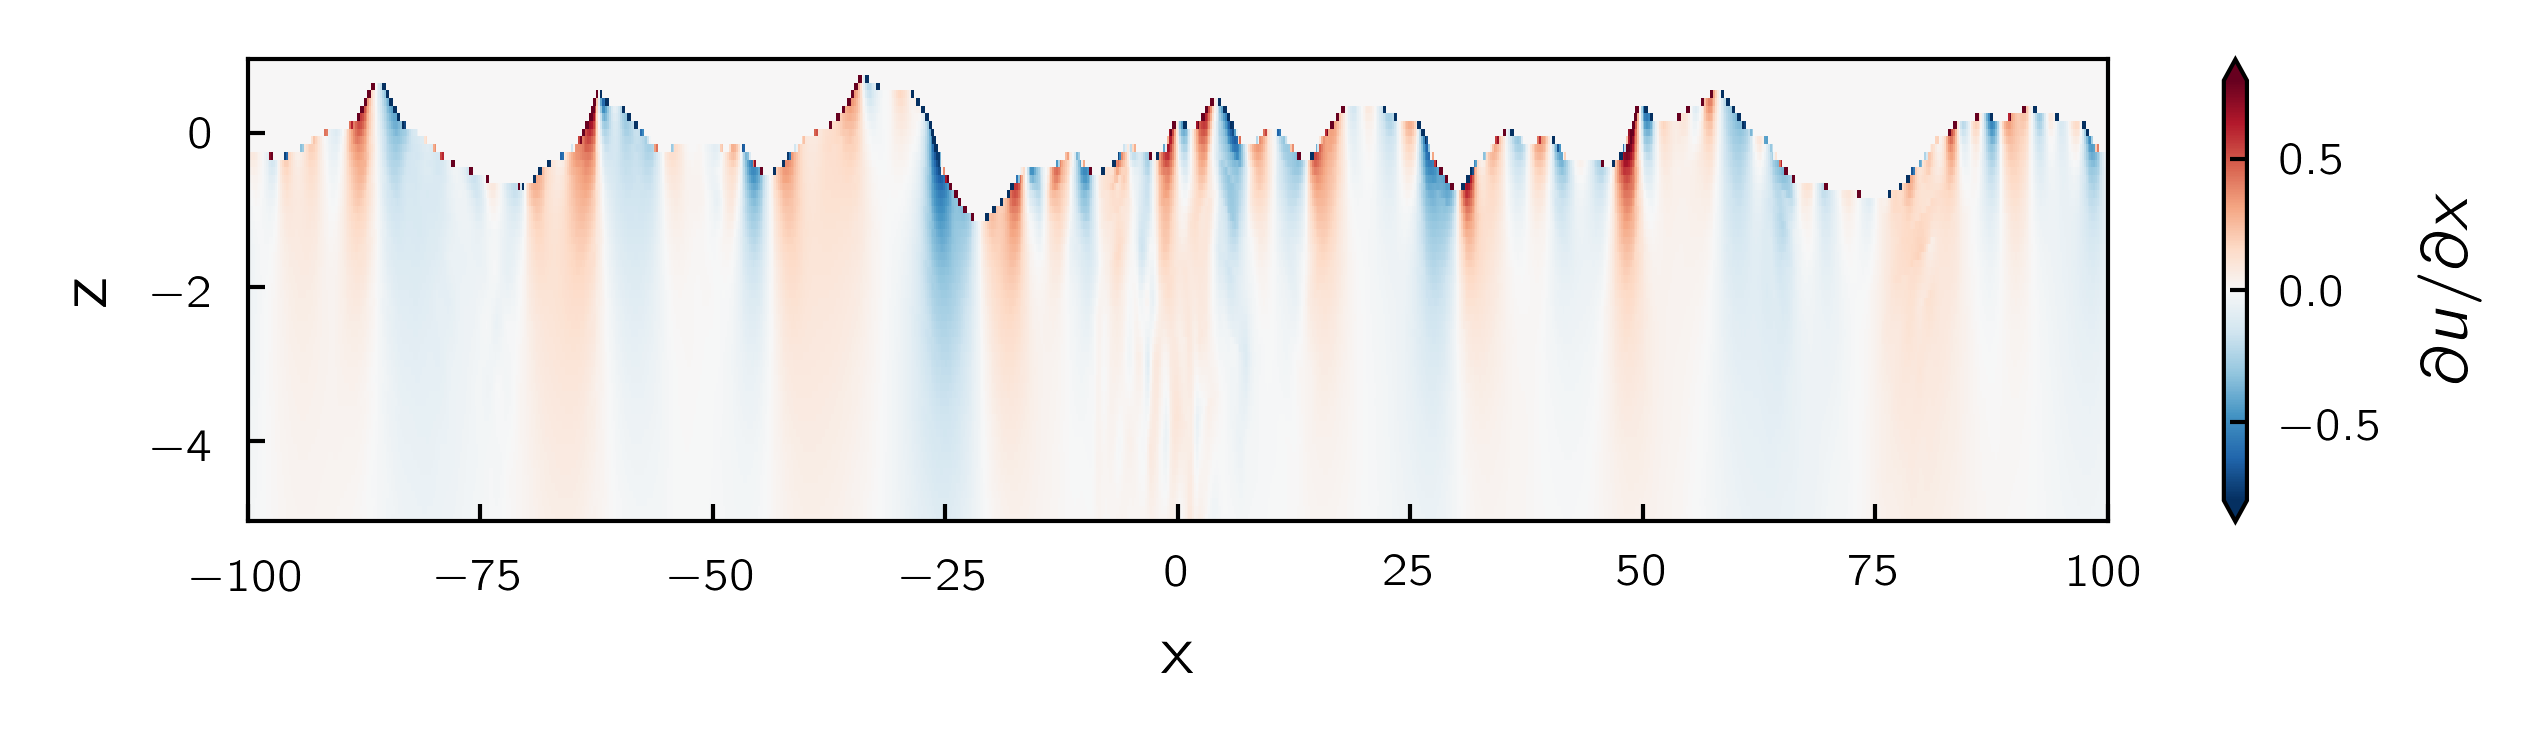

In [177]:
plt.figure(figsize=[5,1])
ds_interp.dudx.isel(y=512).plot(x='x', vmax=0.8, vmin=-0.8, cmap='RdBu_r', cbar_kwargs={'label': '$\partial u/\partial x$'})
plt.title('')

Text(0.5, 1.0, '')

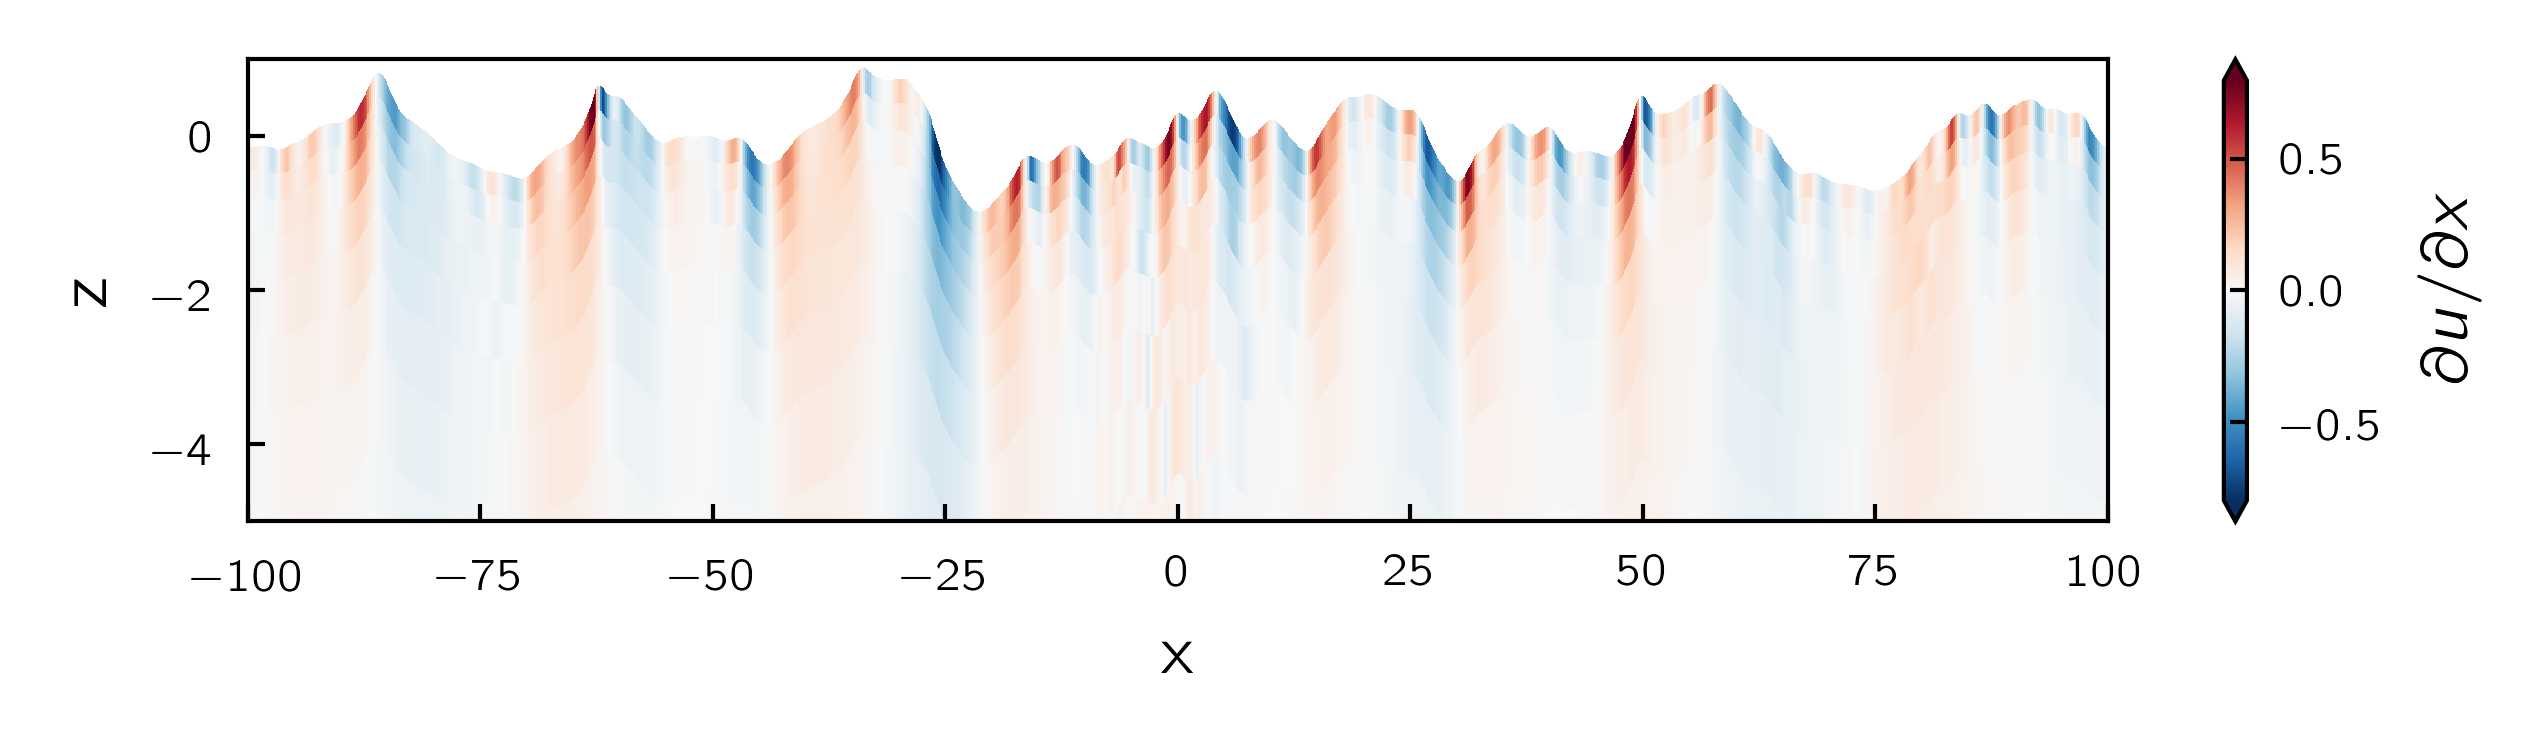

In [176]:
plt.figure(figsize=[5,1])
ds.dudx.isel(t=0,y=512).plot(x='x',y='z', vmax=0.8, vmin=-0.8, cmap='RdBu_r', cbar_kwargs={'label': '$\partial u/\partial x$'})
plt.ylim([-5,1])
plt.title('')

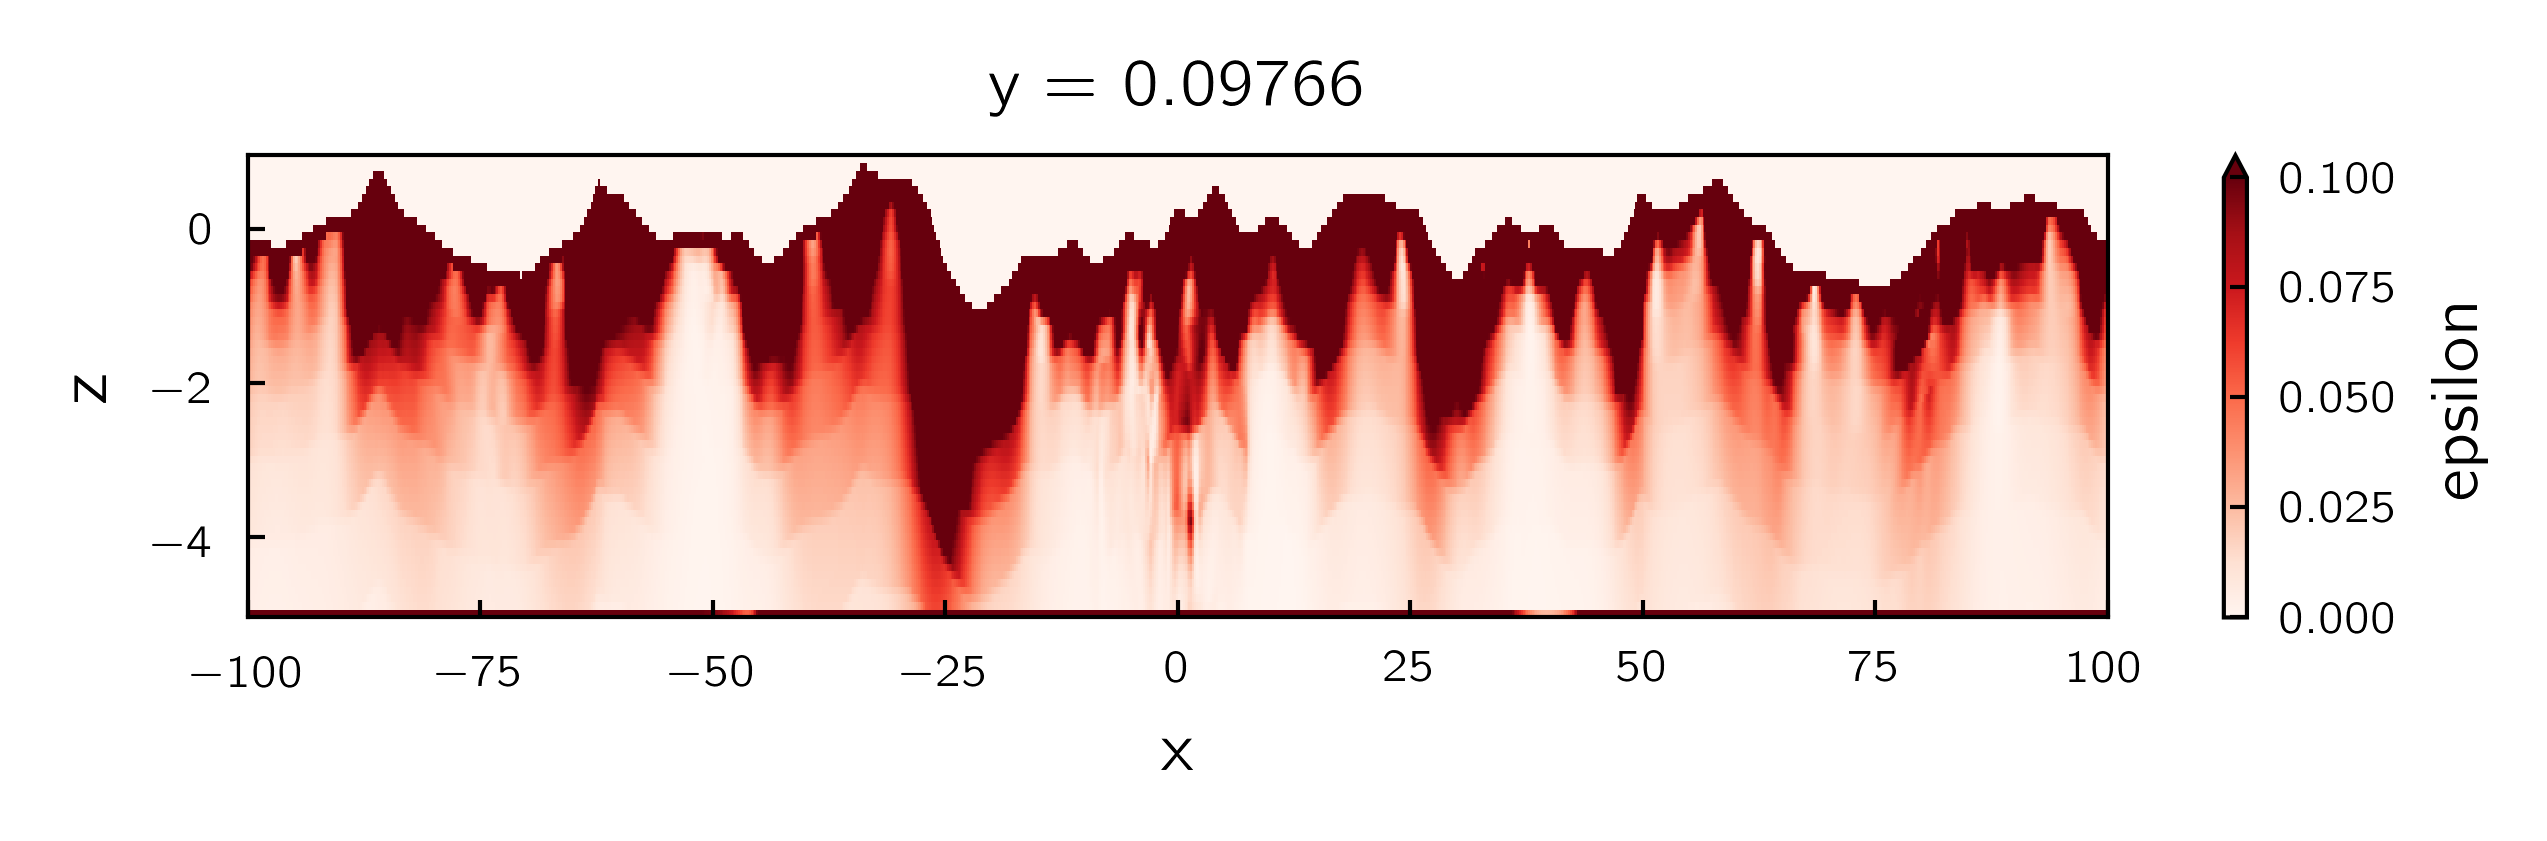

In [162]:
plt.figure(figsize=[5,1])
ds_interp.epsilon.isel(y=512).plot(x='x', vmax=0.1, vmin=0, cmap='Reds')

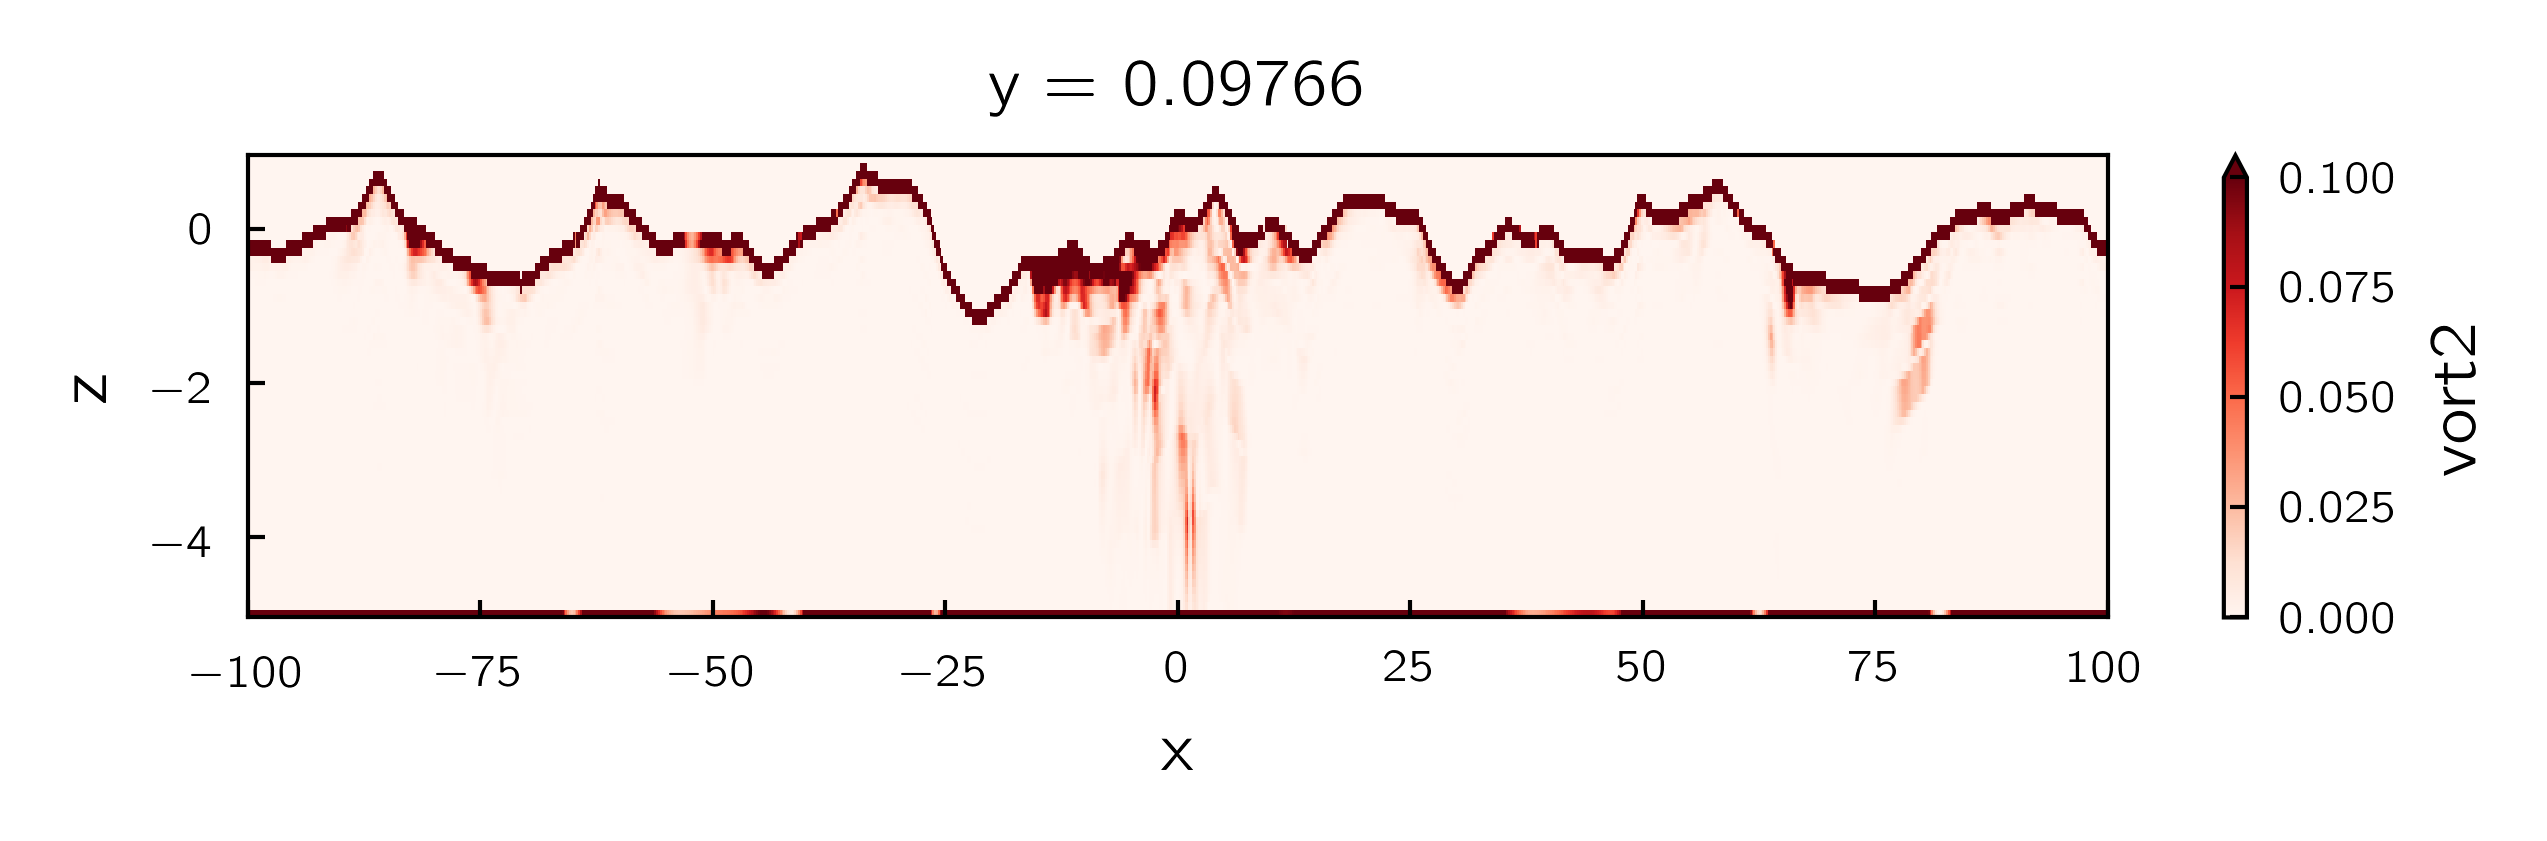

In [163]:
plt.figure(figsize=[5,1])
ds_interp.vort2.isel(y=512).plot(x='x', vmax=0.1, vmin=0, cmap='Reds')